# TD-OFDFT Tutorials

This is the first tutorial in running TD-OFDFT with DFTpy. In this tutorial, you will learn:

- How to run an TD-OFDFT calculation starting from the ground-state density
- How to use the Dynamics class to write a real-time propagation runner
- How to use predictor-correctors
- How to add the nonadiabatic functional as a correction
- How to run an TD-OFDFT calculation starting from the ground-state density from a more accurate functional

## A simple example using adiabatic TFW functional

First we need to load the necessary modules

In [1]:
import numpy as np
from dftpy.grid import DirectGrid
from dftpy.field import DirectField
from dftpy.functional import Functional, TotalFunctional
from dftpy.optimization import Optimization
from dftpy.constants import LEN_CONV, ENERGY_CONV
from dftpy.formats.vasp import read_POSCAR
from dftpy.td.propagator import Propagator
from dftpy.td.hamiltonian import Hamiltonian
from dftpy.utils.utils import calc_rho, calc_j
from dftpy.td.utils import initial_kick

The next step is to prepare the structure of the system. We load the system structure from a vasp POSCAR file and set the grid size to 36 by 36 by 32. We then initialized the density to be uniform electron gas.

In [2]:
structure_file = './Mg8'
atoms = read_POSCAR(structure_file, names=['Mg'])
PP_list = {'Mg':'Mg_OEPP_PZ.UPF'}
nr = [36, 36, 32]
grid = DirectGrid(atoms.cell.lattice, nr, atoms.cell.origin)
nelec = 16
rho_ini = np.ones(nr)
rho_ini = DirectField(grid=grid, griddata_3d=rho_ini)
rho_ini = rho_ini / rho_ini.integral() * nelec

Next, we set up the functionals,

In [3]:
ke = Functional(type='KEDF',name='TFvW')
xc = Functional(type='XC',name='LDA')
hartree = Functional(type='HARTREE')
pseudo = Functional(type='PSEUDO', grid=grid, ions=atoms, PP_list=PP_list)
totalfunctional = TotalFunctional(KineticEnergyFunctional=ke,
                                XCFunctional=xc, 
                                HARTREE=hartree, 
                                PSEUDO=pseudo
                                 )

setting key: Mg -> Mg_OEPP_PZ.UPF


and the optimizer

In [4]:
optimization_options = {
        'econv' : 1e-10 * nelec, # Energy Convergence (a.u./atom)
        'maxfun' : 50,   # For TN method, it's the max steps for searching direction
        'maxiter' : 100, # The max steps for optimization
        }

opt = Optimization(EnergyEvaluator=totalfunctional, optimization_options = optimization_options,
        optimization_method = 'TN')

We optimize the ground state density.

In [5]:
rho0 = opt.optimize_rho(guess_rho=rho_ini)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -8.387459237318E-01     -8.387459E-01   2.343046E+00    1       1       6.605792E-02    
!WARN: Change to steepest decent
1       -1.475975310796E+01     -1.392101E+01   1.122103E+00    1       4       2.030983E-01    
2       -1.578181338396E+01     -1.022060E+00   1.518278E-01    4       2       3.223696E-01    
3       -1.592678257857E+01     -1.449692E-01   1.739021E-02    9       1       4.845536E-01    
4       -1.593537506417E+01     -8.592486E-03   1.159542E-03    5       1       6.012633E-01    
5       -1.593687347200E+01     -1.498408E-03   1.868786E-04    9       2       7.682667E-01    
6       -1.593712492517E+01     -2.514532E-04   3.070880E-05    10      2       9.458644E-01    
7       -1.593715678999E+01     -3.186482E-05   5.229563E-06    8       2       1.102663E+00    
8       -1.593716394301E+01     -7.153019E-06   8.487288E-07    10      2       1.282192E+00  

Now come the TD part. The first thing we need to do is to change the KE functional in the total functional to Pauli functional, e.g., remove the von Weizacker part, because it's handled by the Laplacian part of the Hamiltonian.

In [6]:
ke.options.update({'y':0}) # Kinetic energy functionals with the form xTF+yvW+something has the options x and y which controls how much TF or vW in the functional. Setting y=0 removes the vW part from the functional

We then apply a kick on the ground state density, and prepare the Hamiltonian and the propagator.

In [7]:
direction = 0 # 0, 1, 2 means x, y, z-direction, respectively
k = 1.0e-1 # kick_strength in a.u.
psi = initial_kick(k, direction, np.sqrt(rho0))
j0 = calc_j(psi)
potential = totalfunctional(rho0, current=j0, calcType=['V']).potential
hamiltonian = Hamiltonian(v=potential)
interval = 1 # time interval in a.u. Note this is a relatively large time step. In real calculations you typically want a smaller time step like 1e-1 or 1e-2.
prop = Propagator(hamiltonian, interval, name='crank-nicholson')

Now comes the actual propagation. The easiest way to run it is to use a for loop.

In [8]:
max_steps = 50
for i_t in range(max_steps):
    psi, info = prop(psi)
    rho = calc_rho(psi)
    j = calc_j(psi)
    potential = totalfunctional(rho, current=j, calcType=['V']).potential
    prop.hamiltonian.v = potential

We can check the observables, for example, the dipole moment, at the end of the propagation.

In [9]:
delta_rho = rho - rho0
delta_mu = (delta_rho * delta_rho.grid.r).integral()
print(delta_mu)

[ 3.09496812 -0.22498087 -0.2409203 ]


Alternatively, we can make a class as a child class of Dynamics. This is a more object oriented way of running propagations and also allows us to attach any observation function to record whatever intermediate result we need at each time step.

In [10]:
from dftpy.optimize import Dynamics


class Runner(Dynamics):
    
    def __init__(self, rho0, totalfunctional, k, direction, interval, max_steps):
        super(Runner, self).__init__()
        self.max_steps = max_steps
        self.totalfunctional = totalfunctional
        self.rho0 = rho0
        self.rho = rho0
        self.psi = initial_kick(k, direction, np.sqrt(self.rho0))
        self.j = calc_j(self.psi)
        potential = self.totalfunctional(self.rho0, current=self.j, calcType=['V']).potential
        hamiltonian = Hamiltonian(v=potential)
        self.prop = Propagator(hamiltonian, interval, name='crank-nicholson')
        self.dipole = []
        self.attach(self.calc_dipole) # this attaches the calc_dipole function to the observers list which runs after each time step.
        
    def step(self):
        self.psi, info = self.prop(self.psi)
        self.rho = calc_rho(self.psi)
        self.j = calc_j(self.psi)
        potential = self.totalfunctional(self.rho, current=self.j, calcType=['V']).potential
        self.prop.hamiltonian.v = potential
        
    def calc_dipole(self):
        delta_rho = self.rho - self.rho0
        delta_mu = (delta_rho * delta_rho.grid.r).integral()
        self.dipole.append(delta_mu)

Now that we made the class, we can create an instance of the class and run it.

In [11]:
runner = Runner(rho0, totalfunctional, k, direction, interval, max_steps)
runner()

False

We can plot how the dipole moment changes with time with matplotlib.

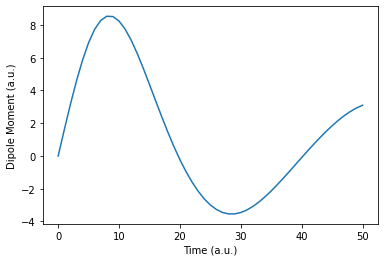

In [12]:
import matplotlib.pyplot as plt

t = np.linspace(0, interval * max_steps, max_steps + 1)
plt.plot(t, [mu[0] for mu in runner.dipole])
plt.xlabel('Time (a.u.)')
plt.ylabel('Dipole Moment (a.u.)')
plt.show()

## Introduction of the predictor-corrector

A predictor-corrector can be used to greatly improve the accuracy of the propagation without the need of using a small time step. DFTpy offers a PredictorCorrector class. Here is an example how to use the PredictorCorrector class for real-time propagation.

In [13]:
from dftpy.td.predictor_corrector import PredictorCorrector


class Runner2(Dynamics):
    
    def __init__(self, rho0, totalfunctional, k, direction, interval, max_steps):
        super(Runner2, self).__init__()
        self.max_steps = max_steps
        self.totalfunctional = totalfunctional
        self.rho0 = rho0
        self.rho = rho0
        self.psi = initial_kick(k, direction, np.sqrt(self.rho0))
        self.j = calc_j(self.psi)
        potential = self.totalfunctional(self.rho0, current=self.j, calcType=['V']).potential
        hamiltonian = Hamiltonian(v=potential)
        self.prop = Propagator(hamiltonian, interval, name='crank-nicholson')
        self.dipole = []
        self.attach(self.calc_dipole)
        self.predictor_corrector = None
        
    def step(self):
        self.predictor_corrector = PredictorCorrector(self.psi, propagator=self.prop, max_steps=2, functionals=totalfunctional)
        self.predictor_corrector()
        self.psi = self.predictor_corrector.psi_pred
        self.rho = self.predictor_corrector.rho_pred
        self.j = self.predictor_corrector.j_pred
        
    def calc_dipole(self):
        delta_rho = self.rho - self.rho0
        delta_mu = (delta_rho * delta_rho.grid.r).integral()
        self.dipole.append(delta_mu)

In [14]:
runner2 = Runner2(rho0, totalfunctional, k, direction, interval, max_steps)
runner2()

False

We can compare the dipole moment with and without the predictor-corrector. We can see noticable differences between them.

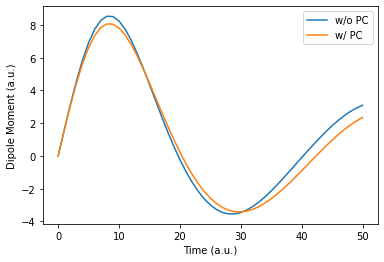

In [15]:
t = np.linspace(0, interval * max_steps, max_steps + 1)
plt.plot(t, [mu[0] for mu in runner.dipole], label='w/o PC')
plt.plot(t, [mu[0] for mu in runner2.dipole], label='w/ PC')
plt.xlabel('Time (a.u.)')
plt.ylabel('Dipole Moment (a.u.)')
plt.legend()
plt.show()

To check whether the predictor-corrector improves the result, we can run a propagation with the time-step 1/10 of the original one,

In [16]:
runner1b = Runner(rho0, totalfunctional, k, direction, interval / 10, max_steps)
runner1b()

False

and we find the result is very close to the one with the predictor-corrector!

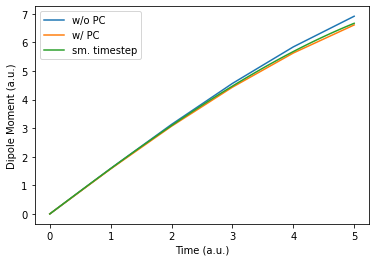

In [17]:
t = np.linspace(0, interval * (max_steps // 10), max_steps // 10 + 1)
t2 = np.linspace(0, interval * (max_steps // 10), max_steps + 1)
plt.plot(t, [mu[0] for mu in runner.dipole][:max_steps // 10 + 1], label='w/o PC')
plt.plot(t, [mu[0] for mu in runner2.dipole][:max_steps // 10 + 1], label='w/ PC')
plt.plot(t2, [mu[0] for mu in runner1b.dipole], label='sm. timestep')
plt.xlabel('Time (a.u.)')
plt.ylabel('Dipole Moment (a.u.)')
plt.legend()
plt.show()

## Using nonadiabatic functionals

In many scenarios to achieve good result in TD-OFDFT, non-adiabatic Pauli potential is required. To use nonadiabatic functionals, one can simply create an instance of the functional and add it to the total functionals.

In [18]:
dyn = Functional(type='DYNAMIC', name='JP1')
totalnonadiabatic = TotalFunctional(KineticEnergyFunctional=ke,
                                XCFunctional=xc, 
                                HARTREE=hartree, 
                                PSEUDO=pseudo,
                                Nonadiabatic=dyn
                                 )
runner2b = Runner2(rho0, totalnonadiabatic, k, direction, interval, max_steps)
runner2b()

False

However, sometimes the above method can cause numerical instablities. In that case, one can use the nonadiabatic functional as a correction, e.g., for each time step, run a normal propagation without the nonadiabatic functional, then run 1st order Taylor propagator with just the nonadiabatic functional after it. Keep in mind this approximation requires the time step to be small, that's why we use time step=0.1 here.

In [19]:
from dftpy.td.utils import PotentialOperator


class Runner3(Runner2):
    
    def __init__(self, rho0, totalfunctional, correction, k, direction, interval, max_steps):
        super(Runner3, self).__init__(rho0, totalfunctional, k, direction, interval, max_steps)
        self.correction = correction
        correct_potential = self.correction(self.rho0 , current=self.j, calcType=['V']).potential
        self.taylor = Propagator(name='taylor', hamiltonian=PotentialOperator(v=correct_potential), interval=interval, order=1)
        self.N = self.rho0.integral()
        self.interval = interval
        
    def step(self):
        correct_potential = self.correction(self.rho , current=self.j, calcType=['V']).potential
        self.taylor.hamiltonian.v = correct_potential
        super(Runner3, self).step()
        self.psi, info = self.taylor(self.psi)
        self.rho = calc_rho(self.psi)
        self.j = calc_j(self.psi)
    
        

In [20]:
runner3 = Runner3(rho0, totalfunctional, dyn, k, direction, interval / 10, max_steps)
runner3()

False

We can notice the effects of the nonadiabatic potential.

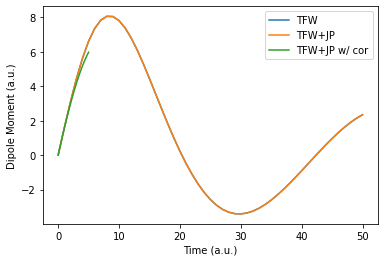

In [21]:
t = np.linspace(0, interval * max_steps, max_steps + 1)
t2 = np.linspace(0, interval / 10 * max_steps, max_steps + 1)
plt.plot(t, [mu[0] for mu in runner2.dipole], label='TFW')
plt.plot(t, [mu[0] for mu in runner2b.dipole], label='TFW+JP')
plt.plot(t2, [mu[0] for mu in runner3.dipole], label='TFW+JP w/ cor')
#plt.plot(t, mua-mub)
plt.xlabel('Time (a.u.)')
plt.ylabel('Dipole Moment (a.u.)')
plt.legend()
plt.show()

## Starting with more accurate ground-state density

Another way to improve the result is to use nonlocal KEDFs for the adiabatic part of the Pauli potential. One can do it by directly replace the ke object with nonlocal functionals in the previous examples. However, nonlocal functionals can be quite costy. To reduce the cost, we can use the nonlocal functionals for just the ground state and do the propagation with TFW. Here is an example of how to set it up.

First we run a ground state optimization with LMGP functional.

In [22]:
lmgp = Functional(type='KEDF',name='LMGP', kfmin=1e-3, kfmax=10, kdd=2)
totalfunctionallmgp = TotalFunctional(KineticEnergyFunctional=lmgp,
                                XCFunctional=xc, 
                                HARTREE=hartree, 
                                PSEUDO=pseudo
                                 )
optimization_options = {
        'econv' : 1e-5 * nelec, # Energy Convergence (a.u./atom)
        'maxfun' : 50,   # For TN method, it's the max steps for searching direction
        'maxiter' : 100, # The max steps for optimization
        }

opt = Optimization(EnergyEvaluator=totalfunctionallmgp, optimization_options = optimization_options,
        optimization_method = 'CG-HS')
rho0_lmgp = opt.optimize_rho(guess_rho=rho_ini)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -8.387459237318E-01     -8.387459E-01   2.343046E+00    1       1       3.136204E+00    
1       -1.515142866267E+01     -1.431268E+01   1.442264E+00    1       4       7.143733E+00    
2       -1.633464139833E+01     -1.183213E+00   8.900099E-01    1       1       8.173652E+00    
3       -1.651334790252E+01     -1.787065E-01   2.773575E-01    1       2       1.019222E+01    
4       -1.660880578423E+01     -9.545788E-02   2.420474E-01    1       2       1.222507E+01    
5       -1.667538730116E+01     -6.658152E-02   1.263650E-01    1       1       1.324655E+01    
6       -1.670938973479E+01     -3.400243E-02   6.448108E-02    1       2       1.526664E+01    
7       -1.672155137927E+01     -1.216164E-02   2.947864E-02    1       2       1.729459E+01    
8       -1.673204801376E+01     -1.049663E-02   4.269679E-02    1       3       2.031026E+01    
9       -1.674553627957E+01   

To have the propagation run correctly, we need to introduce a potential equals the LMGP potential evaluated at the LMGP ground-state density minus the TFW potential evaluated at the same density.

In [23]:
from dftpy.functional.external_potential import ExternalPotential

lmgp.options.update({'y':0})
vtf0 = ke(rho=rho0_lmgp, calcType = {'V'}).potential 
vlmgp0 = lmgp(rho=rho0_lmgp, calcType = {'V'}).potential 
ext = ExternalPotential(v=vlmgp0-vtf0)
totalfunctional.UpdateFunctional(newFuncDict={'ext':ext})

In [24]:
runner2c = Runner2(rho0_lmgp, totalfunctional, k, direction, interval, max_steps)
runner2c()

False

We can see using LMGP ground-state density as the initial condition makes a difference.

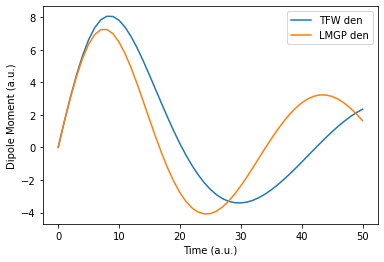

In [25]:
t = np.linspace(0, interval * max_steps, max_steps + 1)
plt.plot(t, [mu[0] for mu in runner2.dipole], label='TFW den')
plt.plot(t, [mu[0] for mu in runner2c.dipole], label='LMGP den')
plt.xlabel('Time (a.u.)')
plt.ylabel('Dipole Moment (a.u.)')
plt.legend()
plt.show()